In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [56]:
import numpy as np
import statsmodels.formula.api as smf
from numpy.linalg import inv
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.linear_model import LogisticRegression as Log_Reg
from statsmodels.regression.linear_model import OLS
from sklearn.cluster import KMeans
import sklearn.preprocessing as Preprocessing
from sklearn.preprocessing import StandardScaler as Standardize
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
from collections import Counter
from operator import itemgetter
%matplotlib inline

## Modeling Election Results

### Introduction

Our primary intention is to predict the popular vote within different states based on trends in the proportion of their names that are biblical. We have demonstrated in our prior analysis that biblicality in naming is associated with higher levels of self-reported Christianity Further, we know that Christianity in America is associated with social conservatism and Republican Party affiliation. Thus, we hypothesize that trends in the biblicality of names can be used to predict the percentage of a state that voted for the Republican party within a given year.

### Methods

We constructed a frequency matrix for each year in our dataset where the $i^{th}$ row corresponds to the $i^{th}$ state and the $j^{th}$ column corresponds to the $j^th$ biblical name, and thus each entry corresponds to the fraction of the population that have that name (so rows do not necessarily sum to 1, and the overall sum is the fraction of the population in that state that have biblical names). This matrix in theory could be used to predict the popular vote in a given state directly but because of its inherently high dimensional nature we would run the risk of overfitting, so some dimensionality reduction is appropriate. As a result we decided to use PCA to transform the matrix from $\mathrm{N_{states}} \times \mathrm{N_{names}}$ to an $N_{states} \times 2$ matrix. This should construct an appropriate linear subspace that accounts variation in biblical naming trends between states that should be useful in predicting the results of presidential elections. 

We also break our approach into two predictive schemas. In the first we try to predict the results of an election in a state by concatenating the PCA vectors for that state from 18 to 75 years ago. With this approach we are thus trying to predict the degree to which a person's religiosity in their environment (as reflected by naming patterns at the time of their birth) is associated with them voting Republican later in life.

The second approach we take is to eschew the 18 to 75 years ago window and instead attempt to directly predict the election results in a given year for a state using that states PCA components in that state. In this case we are imposing a prior assumption on our model that the current years naming patterns are salient and significant enough to be associated with social trends in that state that can be used to predict election results. 

For our modeling target/response we take the percentage of the population that voted for the Republican presidential candidate in the years 1956-2012 (so our response can be indexed by state and year). 



### Data Exploration

First we examine the popular vote in each state for presidential elections between 1988 and 2012.

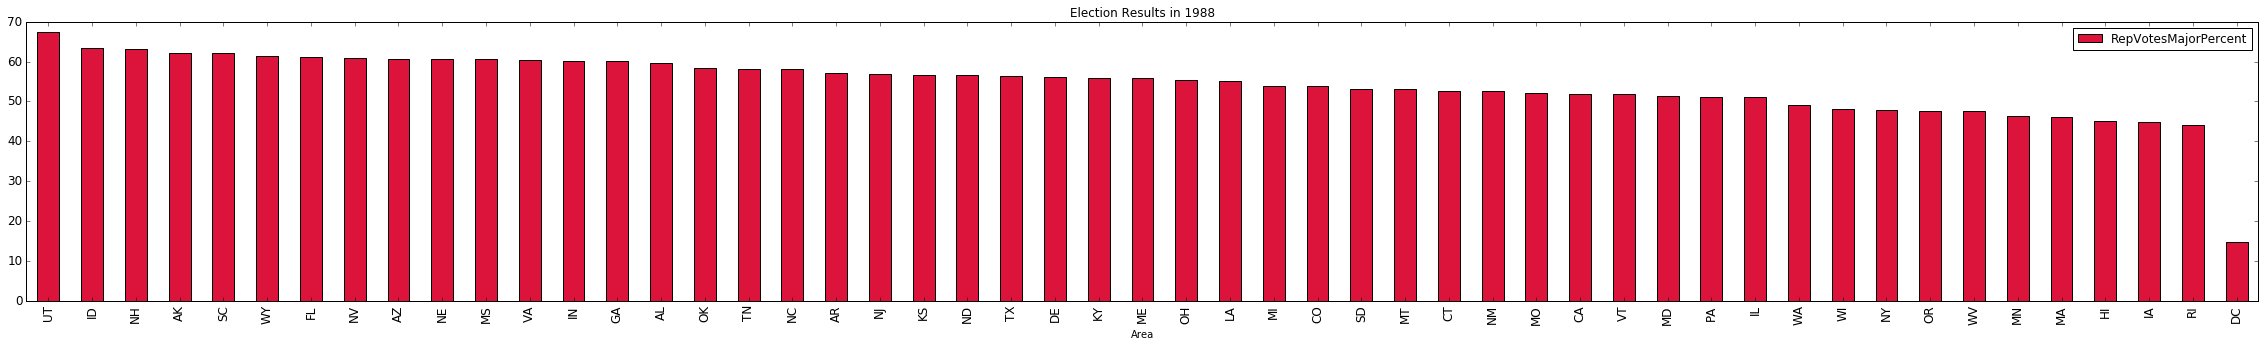

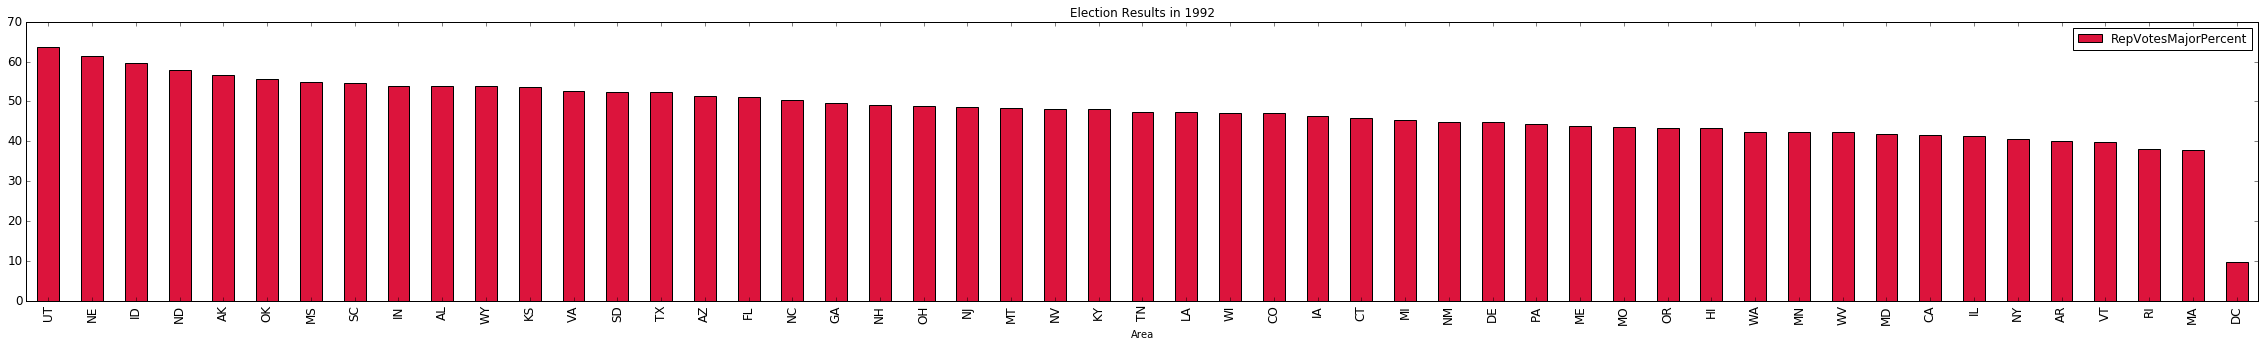

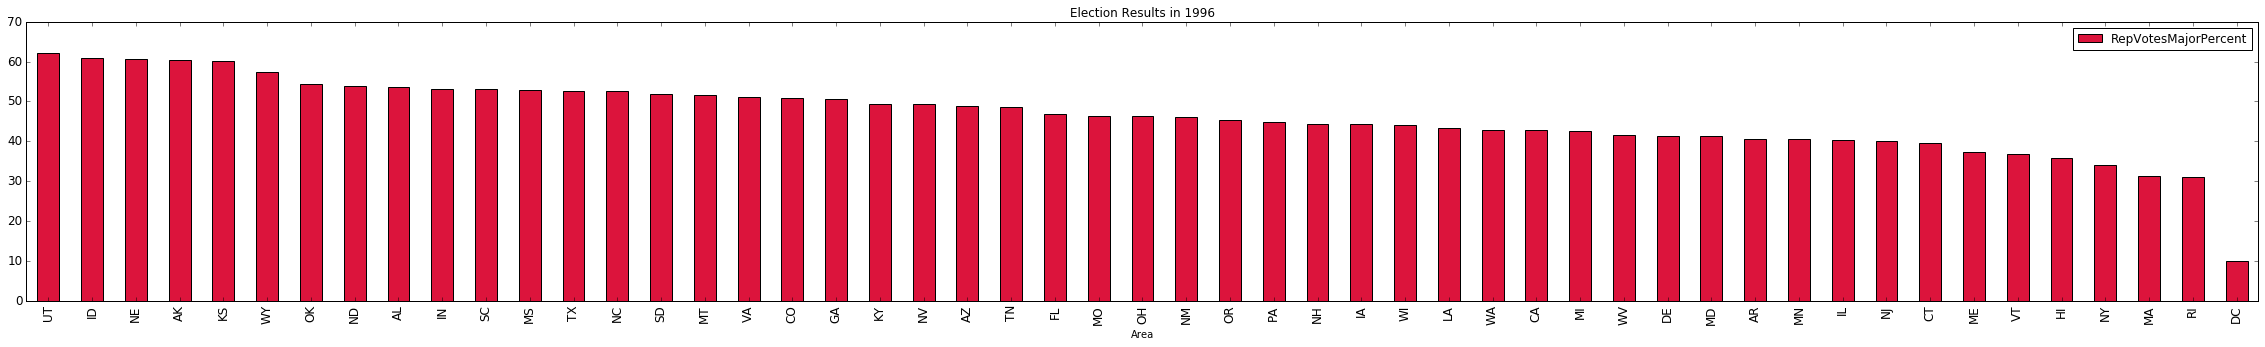

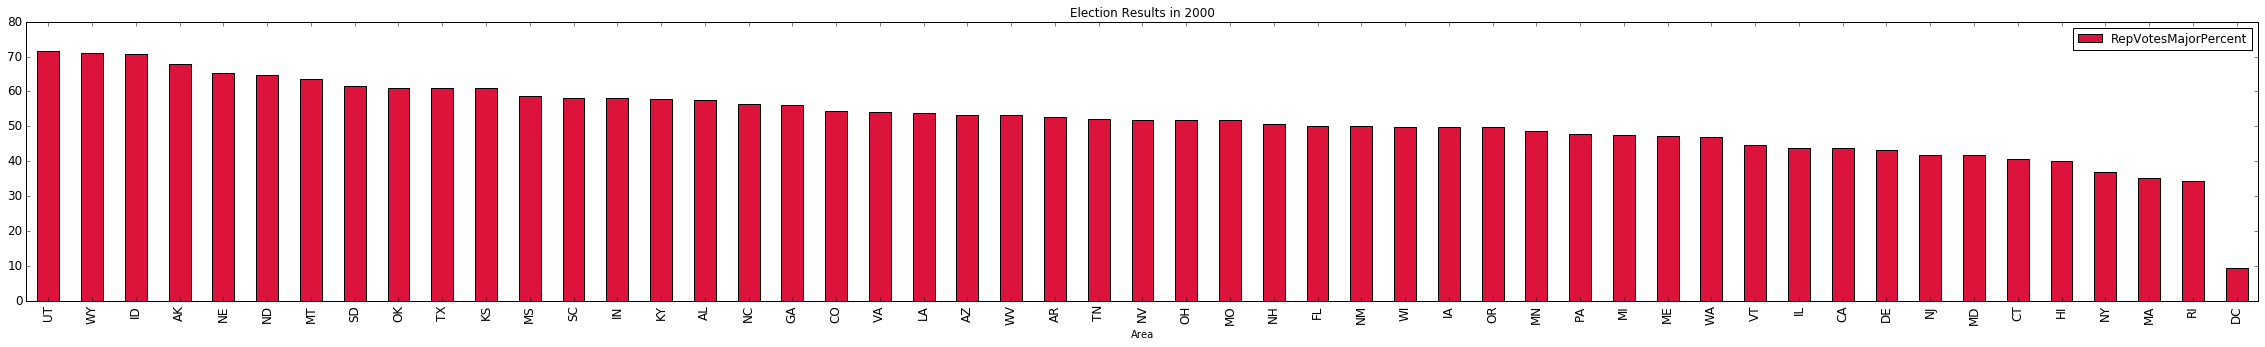

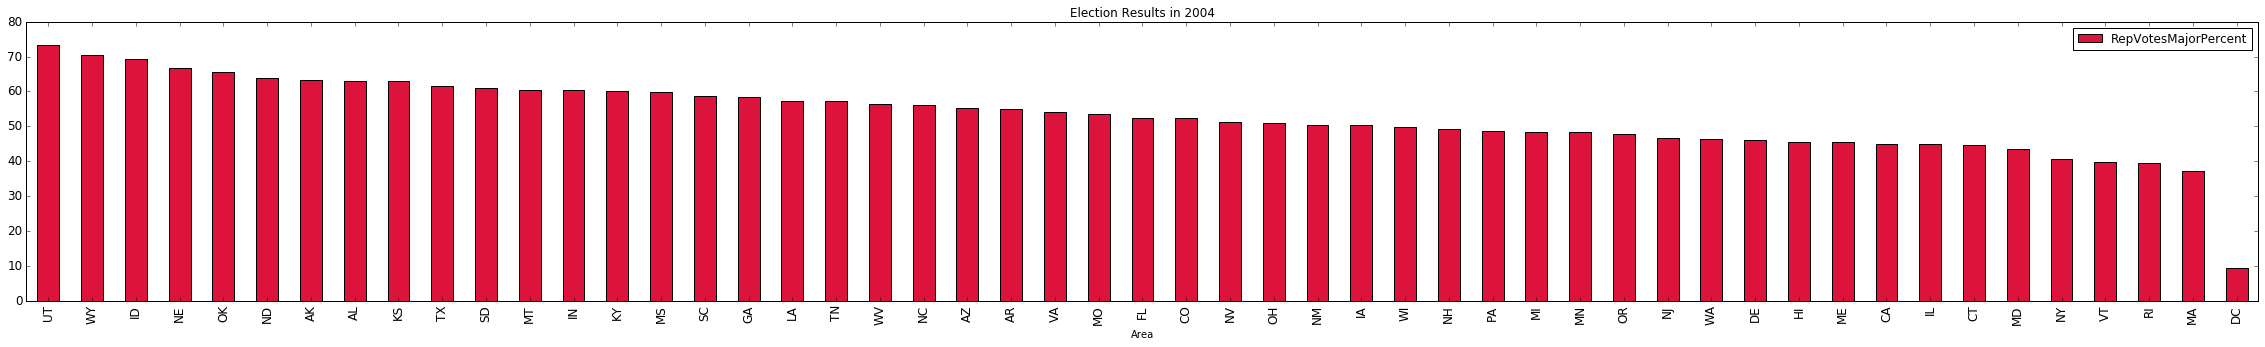

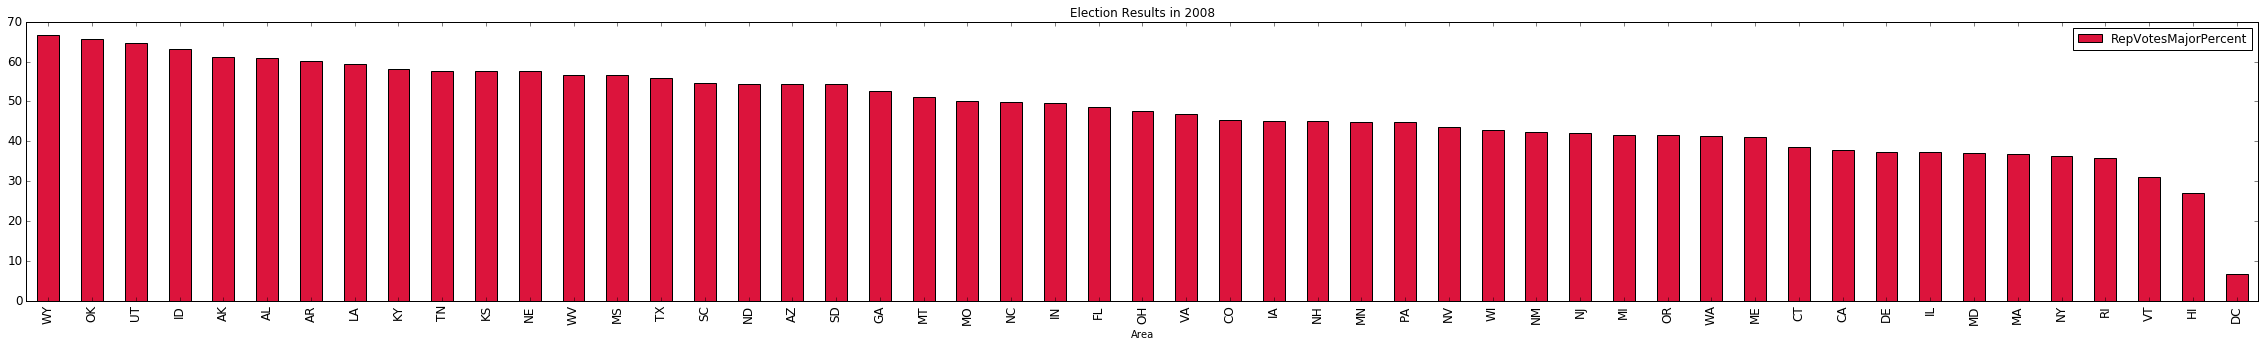

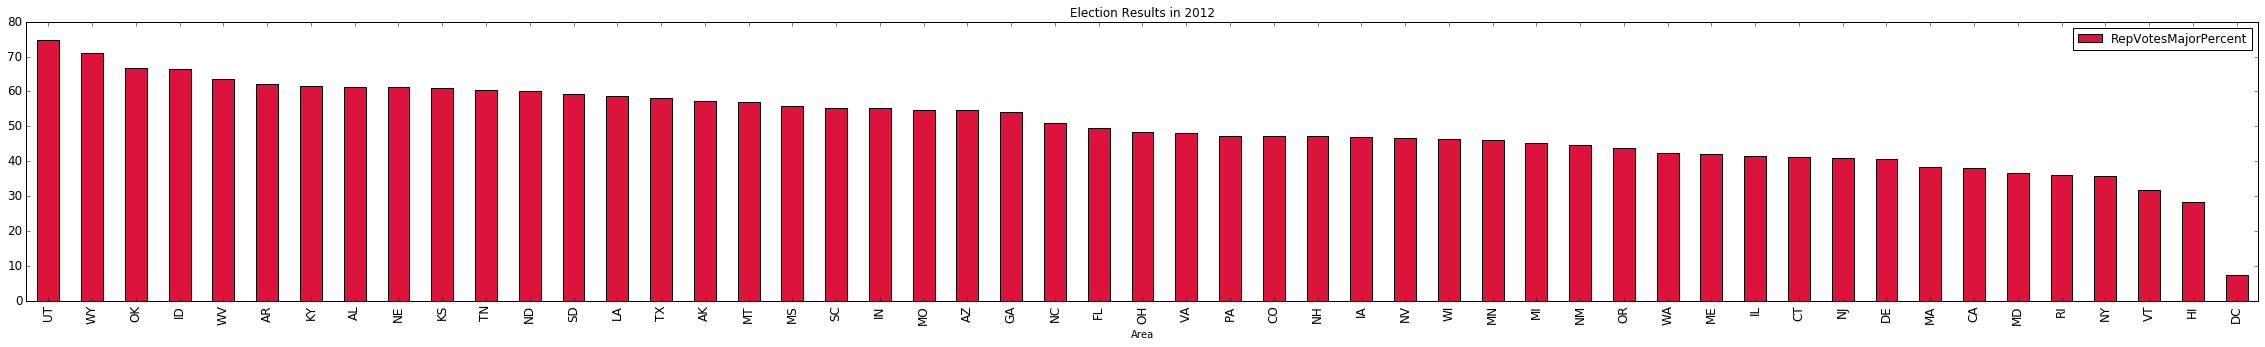

In [29]:
#Import data
election_data_all = pd.read_csv('election_data.csv')

#Create a column with elkection year
election_data_all['RaceYear'] = pd.Series(map(lambda x : int(str(x)[:4]), list(election_data_all['RaceDate'])))

election_data = election_data_all[['RaceYear', 'Area', 'RepVotesMajorPercent']]

#Import yearly name pca for each state and concatenate
names_pca_states = pd.DataFrame()
for year in xrange(1910, 2013):
    dataframe = pd.read_csv('matrices_and_pca/%d_data_pca.csv' % year)
    dataframe.columns = [('%d_PCA1' % year),('%d_PCA2' % year)]
    names_pca_states = pd.concat([names_pca_states, dataframe], axis=1)

#Map states in both files before merging
original_pairs = pd.read_csv('us_states_reordered.csv',header=None)
del original_pairs[2]

original_pairs.columns = ['Name','Abb']
my_dict = original_pairs.set_index('Name')['Abb'].to_dict()

election_data = election_data.replace({"Area":my_dict})

names_pca_states.index = original_pairs.Abb.values

#Explore election dataset
election_names_states = election_data[election_data['RaceYear'] >= 1988]
election_grouped = election_names_states.groupby('RaceYear')

year = 1988

for key,group in election_grouped:
    group = group.sort_values('RepVotesMajorPercent', ascending=False)
    group.plot(x='Area', y='RepVotesMajorPercent', kind='bar', color='crimson', figsize=(40,5),legend=True, fontsize=12, title='Election Results in %d' % year)
    
    year = year + 4

## Presidential Election Results and Incidence of Biblical Names across Voters’ Lifespan:
We first look at presidential election results at each state and election year and their relationship with the different PCA components from each year at each state during the full lifetime of voters aged 18-75. Since this gives us a lot of predictors and high dimensionality problem, we use Ridge regression (for regularization) and Lasso regressions (for regularization and variable selection) and the OLS forward selection. 

In [33]:
#Merge datasets
election_names_states = election_data[election_data['RaceYear'] >= 1988]
holder = []
ctr = 0 
for key,grp in election_names_states.groupby('RaceYear'):

    tmp_votes = grp
    tmp_votes.index = grp.Area

    year_min=int(key)-75
    year_max = int(key)-18

    tmp_vals = names_pca_states.ix[:,('%d_PCA1' % year_min) : ('%d_PCA2' % year_max)]
    tmp_vals = tmp_vals.merge(tmp_votes, left_index=True, right_index=True)
    tmp_vals.columns= range(0,len(tmp_vals.columns))

    if (ctr ==0):
        master_df=tmp_vals
        ctr = ctr+1
    else:
        frms = [master_df,tmp_vals]
        master_df = pd.concat(frms)

master_df = master_df.rename(columns={116:'year', 117:'state', 118 : 'y'})


#Assign x and y 
y = master_df['y']
x = master_df[range(0,116)]

#from http://planspace.org/20150423-forward_selection_with_statsmodels/
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove('y')
    remaining.remove('year')
    remaining.remove('state')
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

#Based on http://planspace.org/20150423-forward_selection_with_statsmodels/

master_df.columns = map(lambda x : 'x' + str(x) if type(x) != str else x, master_df.columns)
model = forward_selected(master_df, 'y')

print model.model.formula
print 'The Forward Selection OLS model score is :', model.rsquared_adj

y ~ x64 + x112 + x17 + x2 + x71 + x98 + x61 + x77 + x50 + x74 + x105 + x59 + x7 + x13 + x33 + x29 + x51 + x100 + x41 + x21 + x65 + x30 + x26 + x37 + x45 + x9 + x10 + x91 + x36 + x46 + x35 + x75 + x53 + x93 + x54 + x22 + x6 + x69 + x78 + x25 + x114 + x90 + x80 + x82 + x70 + x73 + x38 + x113 + 1
The Forward Selection OLS model score is : 0.522726389863


Although the $R^2$ of this model is high this is likely due to overfitting due to the high number of predictors since both Lasso and Ridge regression yield considerably lower scores. 

In [12]:
# Lasso regression
lasso_reg = Lasso_Reg(alpha = 0.01)
lasso_reg.fit(x, y)
score_lasso = lasso_reg.score(x,y)

print 'Lasso score is :', score_lasso

Lasso score is : 0.252190723433


In [13]:
# Standardize data
x_std = Standardize(with_mean=False).fit_transform(x)

# Ridge regression: Fit and evaluate 
ridge_reg = Ridge_Reg(alpha = 0.01)
ridge_reg.fit(x_std, y)
score_ridge = ridge_reg.score(x,y)

print 'Ridge score is :', score_ridge

Ridge score is : 0.0118787512603


### Presidential Election Results and Incidence of Biblical Names of the same year:

We now explore the relationship between election voting results and incidence of biblical names of the same year both at the national level and at the state level. We use linear regression models for this exploration. We construct both a model that predicts the result for an arbitrary state trained on the data from all the states over the years as well as a consortium of 50 models that predict the result for an individual state over the years. We also attempt to instead use Logistic Regression to do a classification of whether a state votes Republican or Democratic.

In [59]:
#Import yearly name pca for each state and concatenate
names_pca_states = pd.DataFrame()
states = election_data["Area"].drop_duplicates().values
election_years = election_data['RaceYear'].unique()
for year in xrange(1910, 2013):
    dataframe = pd.read_csv('matrices_and_pca/%d_data_pca.csv' % year)
    dataframe.columns = [('%d_PCA1' % year),('%d_PCA2' % year)]
    names_pca_states = pd.concat([names_pca_states, dataframe], axis=1)

election_pca = names_pca_states.loc[:, map(lambda x : int(x[:4]) in election_years, names_pca_states.columns)]

election_pca1 = election_pca.loc[:, map(lambda x : x % 2 == 0, xrange(30))]
election_pca2 = election_pca.loc[:, map(lambda x : x % 2 == 1, xrange(30))]

#Set x and y
x = np.concatenate((election_pca1.values.T.reshape(15 * 51, 1), election_pca2.values.T.reshape(15 * 51, 1)), axis=1)
x = np.concatenate((x[:11], x[12:]), axis=0)
y = election_data['RepVotesMajorPercent'].values
t = election_data['RepVotesMajorPercent'].values > 50

#Run a linear regression
model = Lin_Reg().fit(x, y)
print 'The Linear model score is: %.3f'  % model.score(x, y)

#Run a logistic regression
model = Log_Reg().fit(x, t)
print 'The Logistic model score is: %.3f' % model.score(x, t)

The Linear model score is: 0.010
The Logistic model score is: 0.601


As we can see, attempting to construct a single model for all the states doesn't work very well and yields a very low $R^2$. Attempting to instead predict results using models trained on individual states yield us a set of 50 $R^2$ values that we visualize below using both a bar chart and a histogram. 

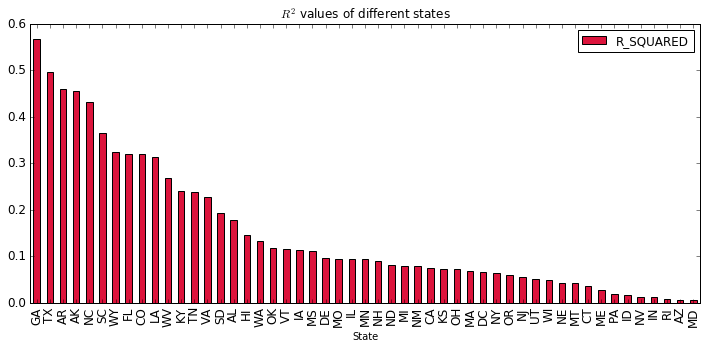

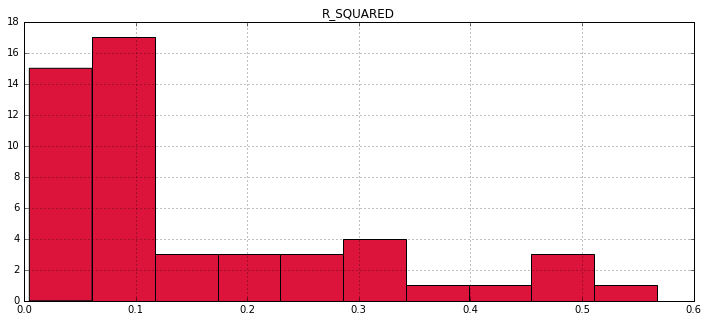

In [103]:
xs = []
ys = []
ts = []

for ii in xrange(51):
    state = states[ii]
    
    if state != 'HI':
        x = election_pca.loc[ii].values.reshape(15, 2)
    else:
        x = election_pca.loc[ii].values.reshape(15, 2)[1:]
    
    y = election_data.loc[election_data['Area'] == state]['RepVotesMajorPercent'].values
    t = y > 50
    
    xs.append(x)
    ys.append(y)
    ts.append(t)

r2s = np.array(map(lambda (x, y) : Lin_Reg().fit(x, y).score(x, y), zip(xs, ys)))
state_results = pd.DataFrame(zip(states, r2s), columns = ['State', 'R_SQUARED'])

state_results = state_results.sort_values('R_SQUARED', ascending=False)
_ = state_results.plot(title='$R^2$ values of different states', y='R_SQUARED', x='State', kind='bar', color='crimson', figsize=(12,5),legend=True, fontsize=12)
_ = state_results.hist(color='crimson', figsize=(12, 5))

### Classification Approach

We also attempt to fit a logistic regression model to instead classify states as voting Democratic or Republican instead of predicting the popular vote. This involves removing states that always vote Republican or Democratic within the time range (since Logistic Regression is pointless in these cases). This isn't really a valuable thing to model due to the fact that there are very small number of datapoints for each state and as such its difficult to improve beyond predicting the party most voted for by the state.

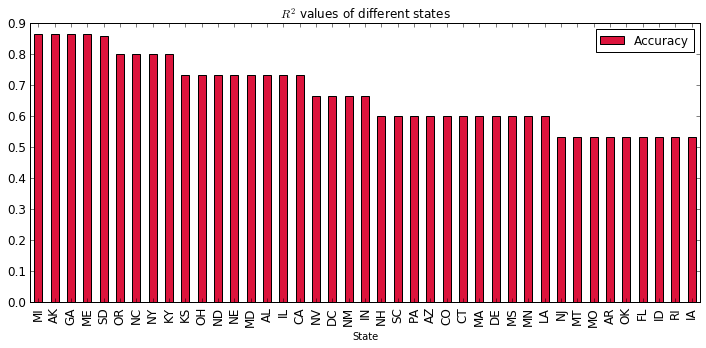

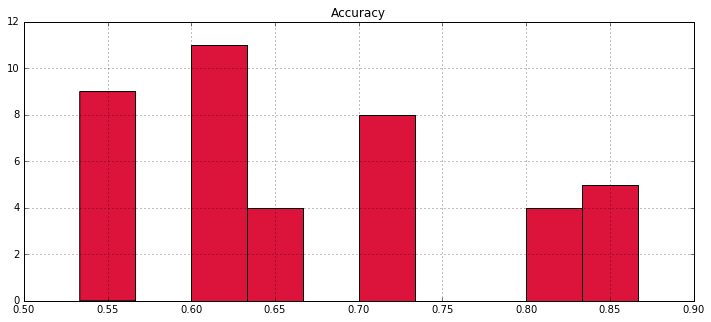

In [105]:
xs, ts = zip(*filter(lambda (a, b) : b.sum() > 0 and b.sum() < 14, zip(xs, ts)))

accs = np.array(map(lambda (a, b) : Log_Reg().fit(a, b).score(a, b), zip(xs, ts)))
state_results = pd.DataFrame(zip(states, accs), columns = ['State', 'Accuracy'])

state_results = state_results.sort_values('Accuracy', ascending=False)

state_results.plot(title='$R^2$ values of different states', y='Accuracy', x='State',kind='bar', color='crimson', figsize=(12,5),legend=True, fontsize=12)

_ = state_results.hist(color='crimson', figsize=(12, 5))